In [91]:
import numpy as np
import pandas as pd
from scipy.stats import norm 
from datetime import datetime
import matplotlib.pyplot as plt

In [92]:
def clean_numeric(value):
    if isinstance(value, str):
        return float(value.replace(',', '').replace('"','')) if value.replace(',', '').replace('"','').replace('-', '').replace('.','').isdigit() else np.nan
    return float(value) if not pd.isna(value) else np.nan

In [93]:
def load_and_clean_option_data(filepath, spot_price):
    try:
        df = pd.read_csv(filepath)
        df = df.dropna(how='all', axis=1)

        # Print debug info about columns
        print(f"\nFile structure - Total columns: {len(df.columns)}")
        print("First 5 columns:", df.columns[:11].tolist())
        print("Last 5 columns:", df.columns[-22:].tolist())
        
        calls = df.iloc[:, :11].copy()
        calls.columns = ['OI', 'CHNG_IN_OI', 'VOLUME', 'IV', 'LTP', 'CHNG', 
                        'BID_QTY', 'BID', 'ASK', 'ASK_QTY', 'STRIKE']
        calls['TYPE'] = 'CALL'
        
        puts = df.iloc[:, 11:].copy()
        # if len(puts.columns) == 9:
        puts.columns = ['OI', 'CHNG_IN_OI', 'VOLUME', 'IV', 'LTP', 'CHNG', 
                        'BID_QTY', 'BID', 'ASK', 'ASK_QTY', 'STRIKE']
        # elif len(puts.columns) == 10:
        #     puts.columns = ['BID_QTY', 'BID', 'ASK', 'ASK_QTY', 'CHNG', 'LTP',
        #                    'IV', 'VOLUME', 'STRIKE_P','CHNG_IN_OI']
        # else:
        #     puts.columns = ['BID_QTY', 'BID', 'ASK', 'ASK_QTY', 'CHNG', 'LTP',
        #                   'IV', 'VOLUME','STRIKE_P','CHNG_IN_OI', 'OI']
        puts['TYPE'] = 'PUT'
        # Drop extra unnamed columns
        # df = df.drop(columns=['Unnamed: 0', 'Unnamed: 22'], errors='ignore')
        
        # # Calls
        # calls = df.iloc[:, :11].copy()
        # calls['STRIKE'] = df['STRIKE']
        # calls.columns = ['OI', 'CHNG_IN_OI', 'VOLUME', 'IV', 'LTP', 'CHNG',
        #                  'BID_QTY', 'BID', 'ASK', 'ASK_QTY', 'STRIKE']
        # calls['TYPE'] = 'CALL'
        
        # # Puts
        # puts = df.iloc[:, 13:].copy()
        # puts.insert(10, 'STRIKE', df['STRIKE'])  # insert strike in right position
        # puts.columns = ['BID_QTY', 'BID', 'ASK', 'ASK_QTY', 'CHNG', 'LTP',
        #                 'IV', 'VOLUME', 'CHNG_IN_OI', 'OI', 'STRIKE']
        # puts['TYPE'] = 'PUT'

        
        options = pd.concat([calls, puts], ignore_index=True)
        
        numeric_cols = ['OI', 'CHNG_IN_OI', 'VOLUME', 'IV', 'LTP', 'CHNG',
                       'BID_QTY', 'BID', 'ASK', 'ASK_QTY', 'STRIKE']
        
        for col in numeric_cols:
            options[col] = options[col].apply(clean_numeric)
        
        options['MID_PRICE'] = (options['BID'] + options['ASK']) / 2
        options['PRICE'] = options['LTP'].fillna(options['MID_PRICE'])
        options['SPOT'] = float(spot_price)
        options['MONEYNESS'] = options['STRIKE'] / spot_price
        
        # Fix date calculation
        expiry_date = datetime(2025, 8, 14)  # Fixed date format
        today = datetime.now()
        options['T'] = (expiry_date - today).days / 365.25  # Convert to float years
        
        options = options.dropna(subset=['STRIKE', 'PRICE', 'IV'])
        options = options[options['IV'] > 0]
        
        print("Data loaded successfully:")
        print(f"Total rows: {len(options)}")
        print(f"CALL rows: {len(options[options['TYPE']=='CALL'])}")
        print(f"PUT rows: {len(options[options['TYPE']=='PUT'])}")
        
        return options  # Always return DataFrame
    
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return pd.DataFrame()  # Return empty DataFrame instead of None

In [94]:
def black_scholes(S, K, T, r, sigma, option_type='CALL'):
    """
    Calculate Black-Scholes option price for European options.
    
    Parameters:
    S (float): Current stock/index price
    K (float): Strike price
    T (float): Time to expiration in years
    r (float): Risk-free interest rate
    sigma (float): Volatility
    option_type (str): 'call' or 'put'
    
    Returns:
    float: Option price
    """
    try:
        if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
            return 
        if not np.isfinite(np.log(S/K)):
            return 
        d1 = np.log(S/K)+ (r + 0.5*sigma**2)*T
        d1 /= (sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        if option_type =='CALL':
            price = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
            print(S)
            print(sigma)
            print(T)
            print(K)
            print(d1)
            print(d2)
            print(norm.cdf(d1))
            print(norm.cdf(d2))
            print(price)
            print("------")
        elif option_type == 'PUT':
            price = K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
        else:
            raise ValueError("option_type must be call or put")
        d1=0
        d2=0
        return float(price)
    except Exception as e:
        return 

In [95]:
def compare_options(filepath, spot_price, risk_free_rate=0.075):
    options = load_and_clean_option_data(filepath, spot_price)
    if options.empty:
        print("no valid data")
        return pd.DataFrame()
    options['BS_PRICE'] = options.apply(
        lambda row: black_scholes(
            S=float(row['SPOT']),
            K=float(row['STRIKE']),
            T=float(row['T']),
            r=float(risk_free_rate),
            sigma=float(row['IV'])/100, # converting it to decimal from % value
            option_type=str(row['TYPE']).upper()
        ), axis=1
    )
    # size=len(options['TYPE'])
    # for x in range(size):
    #     options['BS_PRICE'][x] = black_scholes(
    #         S = float(options['SPOT'][x]), 
    #         K= float(['STRIKE'][x]),
    #         T=float(['T'][x]),
    #         r=float(risk_free_rate),
    #         sigma=float(['IV'][x])/100,
    #         option_type=str(['TYPE'][x]).upper()
    #     )
    
    print(options['BS_PRICE'])
    options['PRICE_DIFF'] = options['BS_PRICE']-options['PRICE']
    options['%_DIFF'] = options['PRICE_DIFF']/options['PRICE']*100

    print(f"Spot Price: {spot_price}")
    print(f"Risk-free Rate: {risk_free_rate*100:.2f}%")
    print(f"Time to Expiry: {options['T'].iloc[0]:.2f} years")
    print(f"Total Options Analyzed: {len(options)}")
    print(f"CALL Options: {len(options[options['TYPE']=='CALL'])}")
    print(f"PUT Options: {len(options[options['TYPE']=='PUT'])}")

    for opt_type in ['CALL','PUT']:
        subset=options[options['TYPE']==opt_type]
        print(f"\n{opt_type} Options Statistics:")
        print(f"Mean IV:{subset['IV'].mean():.2f}%")
        print(f"Mean Price Difference:{subset['PRICE_DIFF'].mean():.2f}")
        print(f"Mean Percentage Difference:{subset['%_DIFF'].mean():.2f}")


    
        plt.figure(figsize=(15, 10))

        # price vs bs_price
        plt.subplot(3, 1, 1)
        for opt_type, color in [('CALL', 'green'), ('PUT', 'red')]:
            subset = options[options['TYPE'] == opt_type]
            plt.scatter(subset['PRICE'], subset['BS_PRICE'], 
                        alpha=0.5, color=color, label=opt_type)
        plt.plot([options['PRICE'].min(), options['PRICE'].max()],
                 [options['PRICE'].min(), options['PRICE'].max()], 'k--')
        plt.xlabel('Market Price')
        plt.ylabel('Black-Scholes Price')
        plt.title('Market Price vs Black-Scholes Price')
        plt.legend()

        # price diff by moneyness
        plt.subplot(3, 1, 2)
        for opt_type, color in [('CALL', 'green'), ('PUT', 'red')]:
            subset = options[options['TYPE'] == opt_type].sort_values('MONEYNESS')
            plt.scatter(subset['MONEYNESS'], subset['%_DIFF'], 
                        alpha=0.5, color=color, label=opt_type)
        plt.axhline(0, color='black', linestyle='--')
        plt.xlabel('Moneyness (Strike/Spot)')
        plt.ylabel('Percentage Difference (%)')
        plt.title('Black-Scholes Pricing Error by Moneyness')
        plt.legend()

        # distribution of percentage diff
        plt.subplot(3, 1, 3)
        for opt_type, color in [('CALL', 'green'), ('PUT', 'red')]:
            subset = options[options['TYPE'] == opt_type]
            plt.hist(subset['%_DIFF'], bins=30, alpha=0.5, 
                     color=color, label=opt_type)
        plt.xlabel('Percentage Difference (%)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Pricing Errors')
        plt.legend()
        
        plt.tight_layout()
        plt.show()    
    return options


File structure - Total columns: 22
First 5 columns: ['OI', 'CHNG IN OI', 'VOLUME', 'IV', 'LTP', 'CHNG', 'BID QTY', 'BID', 'ASK', 'ASK QTY', 'STRIKE']
Last 5 columns: ['OI', 'CHNG IN OI', 'VOLUME', 'IV', 'LTP', 'CHNG', 'BID QTY', 'BID', 'ASK', 'ASK QTY', 'STRIKE', 'OI.1', 'CHNG IN OI.1', 'VOLUME.1', 'IV.1', 'LTP.1', 'CHNG.1', 'BID QTY.1', 'BID.1', 'ASK.1', 'ASK QTY.1', 'STRIKE.1']
Data loaded successfully:
Total rows: 134
CALL rows: 71
PUT rows: 63
24500.3
0.3109
0.0054757015742642025
23000.0
2.77608172433116
2.7530757512353854
0.9972490811488013
0.9970480883024375
1510.2114010408768
------
24500.3
0.1379
0.0054757015742642025
23550.0
3.92209143080296
3.911887108866944
0.9999561081666777
0.9999542111398118
959.9719940711002
------
24500.3
0.1885
0.0054757015742642025
23600.0
2.7204562326935067
2.7065076127882204
0.9967404049338494
0.9966002488301733
910.3301289301562
------
24500.3
0.1787
0.0054757015742642025
23650.0
2.7088530394795716
2.695629599813393
0.996624188075259
0.99648721291

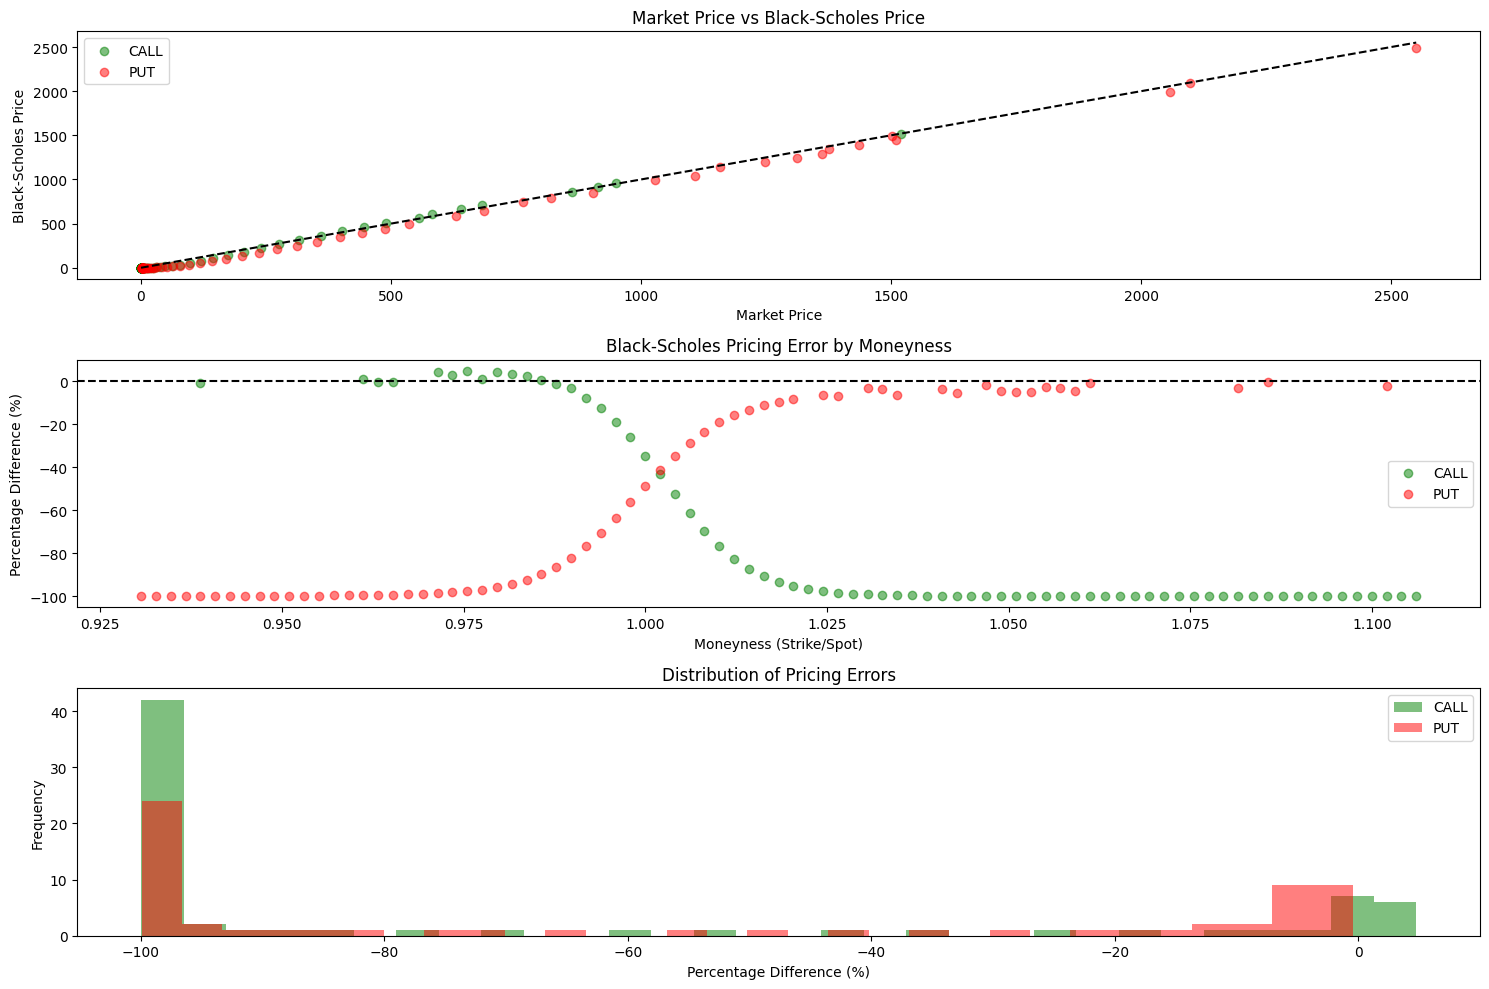


PUT Options Statistics:
Mean IV:18.08%
Mean Price Difference:-31.57
Mean Percentage Difference:-55.84


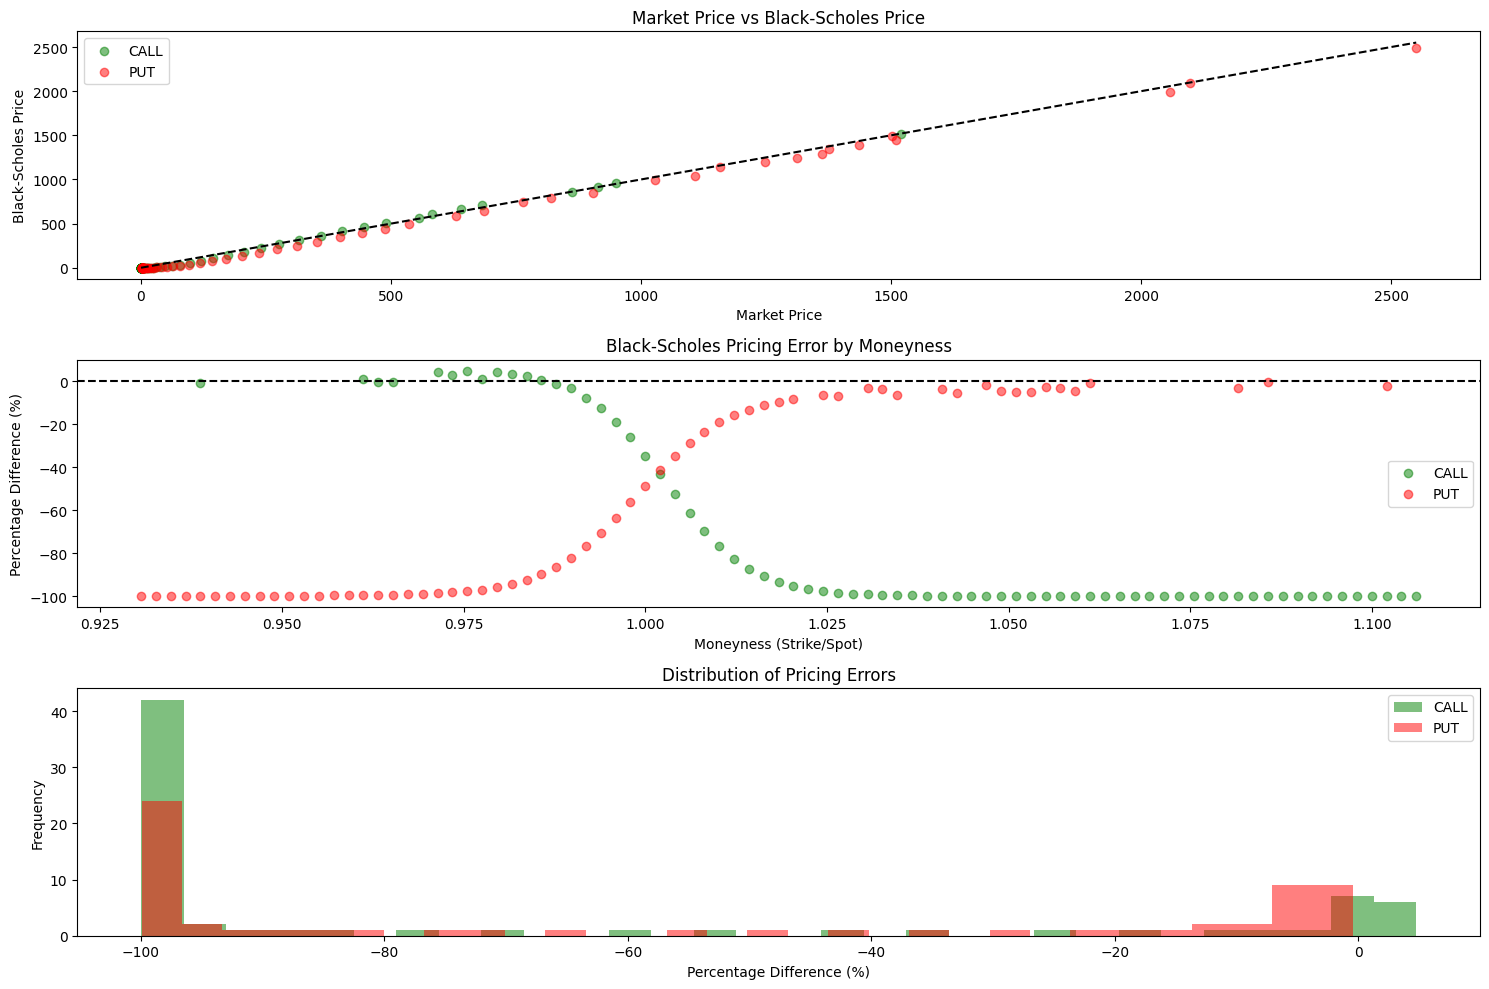


Results saved to 'nifty50_bs_analysis_results.csv'


In [96]:
if __name__ == "__main__":
    # File path to your CSV
    CSV_PATH = "option-chain-ED-NIFTY-14-Aug-2025.csv"
    
    # Current Nifty50 spot price (you need to provide this)
    SPOT_PRICE = 24500.30  # Example - replace with actual spot price
    
    # Risk-free rate (using 7.5% as an example)
    RISK_FREE_RATE = 0.075
    
    # Run analysis
    results = compare_options(CSV_PATH, SPOT_PRICE, RISK_FREE_RATE)
    
    # Save results to CSV
    if not results.empty:
        results.to_csv("nifty50_bs_analysis_results_8.csv", index=False)
        print("\nResults saved to 'nifty50_bs_analysis_results.csv'")
    else:
        print("No result to save")